In [70]:
import cox
from cox.readers import CollectionReader
import os 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from delphi.utils.model_utils import make_and_restore_model
from delphi.utils.datasets import CIFAR

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'
ROOT = '/home/gridsan/stefanou/'
EXP = 'cosine_lr_noised_mom_7_5_50_epochs'
# constants 
BASE_CLASSIFIER = '/base_classifier/'
LOGIT_BALL_CLASSIFIER = '/logit_ball/'
STANDARD_CLASSIFIER = '/standard_classifier/'

In [64]:
def plot(logs, metadata, class_): 
    # iterate over learning rates
#     for i, lr in enumerate(LEARNING_RATES):
    for i, lr in enumerate(np.sort(metadata.lr.unique())): 
        # extract meta logs of interest 
        meta_logs = metadata[(metadata.lr == lr)]        
        
        fig, ax = plt.subplots(2, 2, figsize=(10, 7.5), constrained_layout=True)
#         for j, weight_decay in enumerate(WEIGHT_DECAYS):
        for j, weight_decay in enumerate(meta_logs.weight_decay.unique()):
            lr_logs = logs[logs.exp_id.isin(meta_logs[meta_logs.weight_decay == weight_decay].exp_id)]
            if len(lr_logs) == 0: 
                continue
            # plot loss curves
            sns.lineplot(data=lr_logs, x='epoch', y='train_loss', label='{} weight decay'.format(weight_decay), ax=ax[0, 0])
            sns.lineplot(data=lr_logs, x='epoch', y='val_loss', label='{} weight decay'.format(weight_decay), ax=ax[1, 0])
            
            # plot accuracy curves
            sns.lineplot(data=lr_logs, x='epoch', y='train_prec1', label='{} weight decay'.format(weight_decay), ax=ax[0, 1])
            sns.lineplot(data=lr_logs, x='epoch', y='val_prec1', label='{} weight decay'.format(weight_decay), ax=ax[1, 1])
            
        ax[0, 0].set_title('{} Train Loss: lr - {}'.format(class_, lr))
        ax[0, 0].set_xlabel('Epoch')
        ax[0, 0].set_ylabel('CE Loss')
        ax[1, 0].set_title('{} Validation Loss: lr - {}'.format(class_, lr))
        ax[1, 0].set_xlabel('Epoch')
        ax[1, 0].set_ylabel('CE Loss')
        ax[0, 0].legend()
        ax[1, 0].legend()
        ax[0, 1].set_title('{} Train Accuracy: lr - {}'.format(class_, lr))
        ax[0, 1].set_xlabel('Epoch')
        ax[0, 1].set_ylabel('Accuracy')
        ax[1, 1].set_title('{} Val Accuray: lr - {}'.format(class_, lr))
        ax[1, 1].set_xlabel('Epoch')
        ax[1, 1].set_ylabel('Accuracy')
        ax[0, 1].legend()
        ax[1, 1].legend()
        plt.show()
        
def plot_test_results(base, trunc, standard, type_):
    for i, lr in enumerate(base.lr.unique()): 
        logs_ = base[base.lr == lr].sort_values(by=['weight_decay'])
        trunc_logs_ = trunc[trunc.lr == lr].sort_values(by=['weight_decay'])
        standard_logs_ = standard[standard.lr == lr].sort_values(by=['weight_decay'])
        sns.lineplot(data=logs_, x='weight_decay', y='test_prec1', label='base')
        sns.lineplot(data=trunc_logs_, x='weight_decay', y='test_prec1', label='trunc ce')
        sns.lineplot(data=standard_logs_, x='weight_decay', y='test_prec1', label='standard')
        plt.xlabel('Weight Decay')
        plt.ylabel('Accuracy')
        plt.title('{} Test Accuracy : {} lr'.format(type_, lr))
        plt.legend()
        plt.show()

In [71]:
base_reader = CollectionReader(ROOT + EXP + BASE_CLASSIFIER)
base_logs = base_reader.df('logs')
base_metadata = base_reader.df('metadata')
unseen = base_reader.df('unseen')
test = base_reader.df('test')
trunc_train = base_reader.df('trunc_train')
train_base = base_reader.df('train_base')
base_reader.close()

trunc_reader = CollectionReader(ROOT + EXP + LOGIT_BALL_CLASSIFIER)
trunc_logs = trunc_reader.df('logs')
trunc_metadata = trunc_reader.df('metadata')
trunc_unseen = trunc_reader.df('unseen')
trunc_test = trunc_reader.df('test')
trunc_trunc_train = trunc_reader.df('trunc_train')
trunc_train_base = trunc_reader.df('train_base')
trunc_reader.close()

standard_reader = CollectionReader(ROOT + EXP + STANDARD_CLASSIFIER)
standard_logs = standard_reader.df('logs')
standard_metadata = standard_reader.df('metadata')
standard_unseen = standard_reader.df('unseen')
standard_test = standard_reader.df('test')
standard_trunc_train = standard_reader.df('trunc_train')
standard_train_base = standard_reader.df('train_base')
standard_reader.close()

100%|██████████| 15/15 [00:01<00:00, 13.74it/s]


In [16]:
N = 5

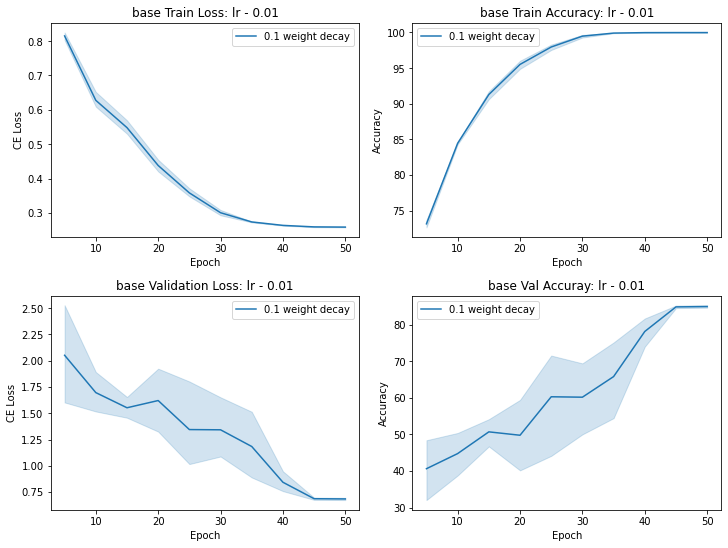

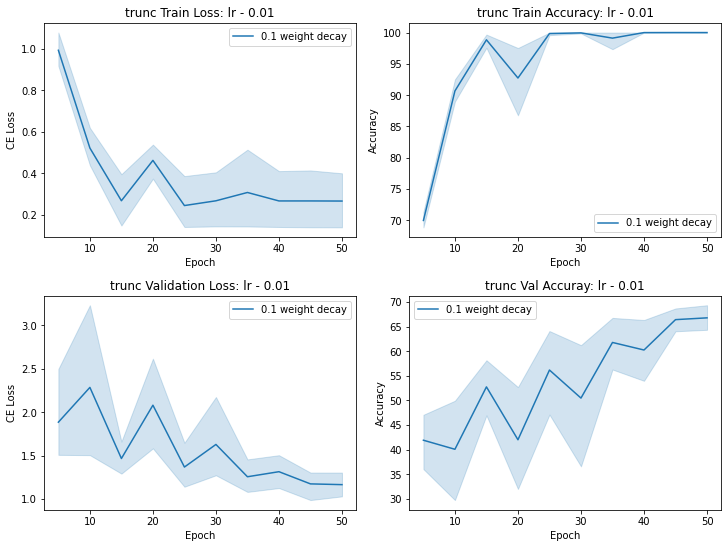

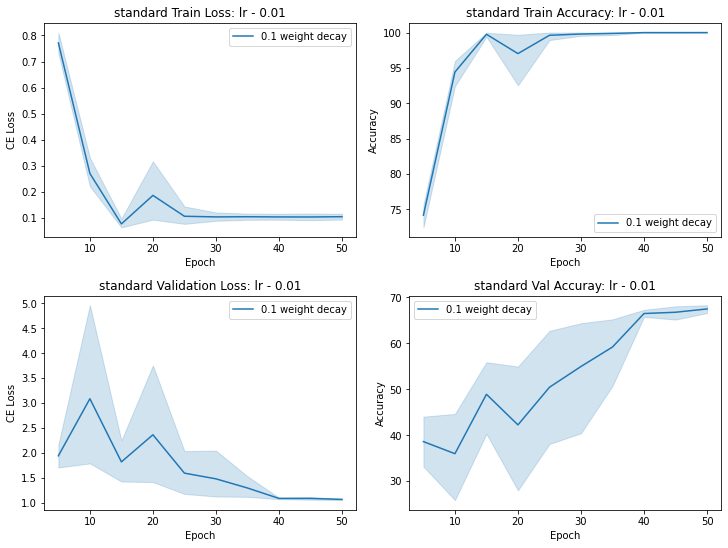

In [5]:
plot(base_logs[base_logs['epoch'] % N == 0], base_metadata, 'base')
plot(trunc_logs[trunc_logs['epoch'] % N == 0], trunc_metadata, 'trunc')
plot(standard_logs[standard_logs['epoch'] % N == 0], standard_metadata, 'standard')

In [32]:
# iterate over learning rates
def filter_(metadata, unseen, test, trunc_train, train_base):
    # iterate over learning rates
    for i, lr in enumerate(metadata.lr.unique()): 
        # experiment ids
        exp_ids = metadata[metadata.lr.isin([lr])].exp_id

        # use .apply() to find exp id for every experiment                       
        unseen['lr'] =  unseen.apply(lambda row: metadata[metadata.exp_id == row['exp_id']]['lr'], axis=1)
        test['lr'] = test.apply(lambda row: metadata[metadata.exp_id == row['exp_id']]['lr'], axis=1)
        trunc_train['lr'] = trunc_train.apply(lambda row: metadata[metadata.exp_id == row.exp_id]['lr'], axis=1)
        train_base['lr'] = train_base.apply(lambda row: metadata[metadata.exp_id == row.exp_id]['lr'], axis=1)
        
    for i, weight_decay in enumerate(metadata.weight_decay.unique()): 
        # experiment ids
        exp_ids = metadata[metadata.weight_decay.isin([weight_decay])].exp_id

        # use .apply() to find exp id for every experiment                       
        unseen['weight_decay'] =  unseen.apply(lambda row: metadata[metadata.exp_id == row['exp_id']]['weight_decay'], axis=1)
        test['weight_decay'] = test.apply(lambda row: metadata[metadata.exp_id == row['exp_id']]['weight_decay'], axis=1)
        trunc_train['weight_decay'] = trunc_train.apply(lambda row: metadata[metadata.exp_id == row.exp_id]['weight_decay'], axis=1)
        train_base['weight_decay'] = train_base.apply(lambda row: metadata[metadata.exp_id == row.exp_id]['weight_decay'], axis=1)
    return unseen, test, trunc_train, train_base

unseen_, test_, trunc_train_, train_base_ = filter_(base_metadata, unseen, test, trunc_train, train_base)
trunc_unseen_, trunc_test_, trunc_trunc_train_, trunc_train_base_ = filter_(trunc_metadata, trunc_unseen, trunc_test, trunc_trunc_train, trunc_train_base)
standard_unseen_, standard_test_, standard_trunc_train_, standard_train_base_ = filter_(standard_metadata, standard_unseen, standard_test, standard_trunc_train, standard_train_base)

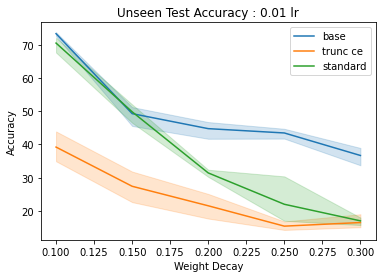

In [33]:
plot_test_results(unseen_, trunc_unseen_, standard_unseen_, 'Unseen')

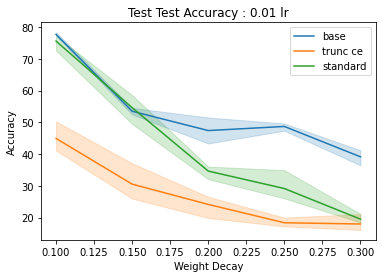

In [34]:
plot_test_results(test_, trunc_test_, standard_test_, 'Test')

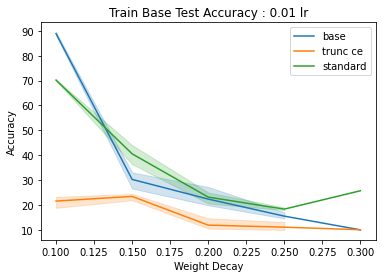

In [26]:
plot_test_results(train_base_, trunc_train_base_, standard_train_base_, 'Train Base')

In [72]:
def plot_momentum(metadata, logs_, class_):
    for i, mom in enumerate(metadata['momentum'].unique()): 
        meta_logs = metadata[metadata.momentum == mom]       
        fig, ax = plt.subplots(2, 2, figsize=(10, 7.5), constrained_layout=True)
        for j, wd in enumerate(metadata.weight_decay.unique()): 

            logs = logs_[logs_.exp_id.isin(meta_logs[meta_logs.weight_decay == wd].exp_id)]
            
            sns.lineplot(data=logs, x='epoch', y='train_loss', label='Weight Decay: {}  - Train Loss'.format(wd), ax=ax[0, 0])
            sns.lineplot(data=logs, x='epoch', y='val_loss', label='Weight Decay: {}  - Val Loss'.format(wd), ax=ax[1, 0])


            sns.lineplot(data=logs, x='epoch', y='train_prec1', label='Weight Decay: {}  - Train Accuracy'.format(wd), ax=ax[0, 1])
            sns.lineplot(data=logs, x='epoch', y='val_prec1', label='Weight Decay: {}  - Val Accuracy'.format(wd), ax=ax[1, 1])        
        ax[0, 0].set_title('{} Train Loss: Momentum - {}'.format(class_, mom))
        ax[0, 0].set_xlabel('Epoch')
        ax[0, 0].set_ylabel('CE Loss')
        ax[1, 0].set_title('{} Validation Loss: Momentum - {}'.format(class_, mom))
        ax[1, 0].set_xlabel('Epoch')
        ax[1, 0].set_ylabel('CE Loss')
        ax[0, 0].legend()
        ax[1, 0].legend()
        ax[0, 1].set_title('{} Train Accuracy: Momentum - {}'.format(class_, mom))
        ax[0, 1].set_xlabel('Epoch')
        ax[0, 1].set_ylabel('Accuracy')
        ax[1, 1].set_title('{} Val Accuray: Momentum - {}'.format(class_, mom))
        ax[1, 1].set_xlabel('Epoch')
        ax[1, 1].set_ylabel('Accuracy')
        ax[0, 1].legend()
        ax[1, 1].legend()
        plt.show()        

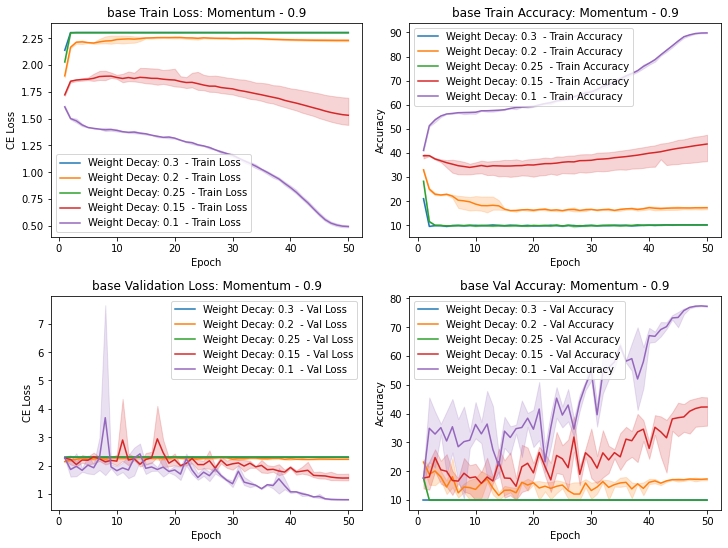

In [73]:
plot_momentum(base_metadata, base_logs, 'base')

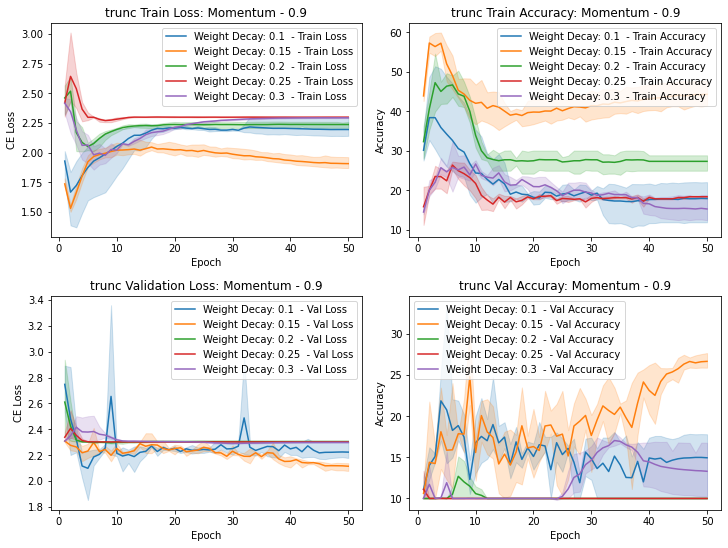

In [74]:
plot_momentum(trunc_metadata, trunc_logs, 'trunc')

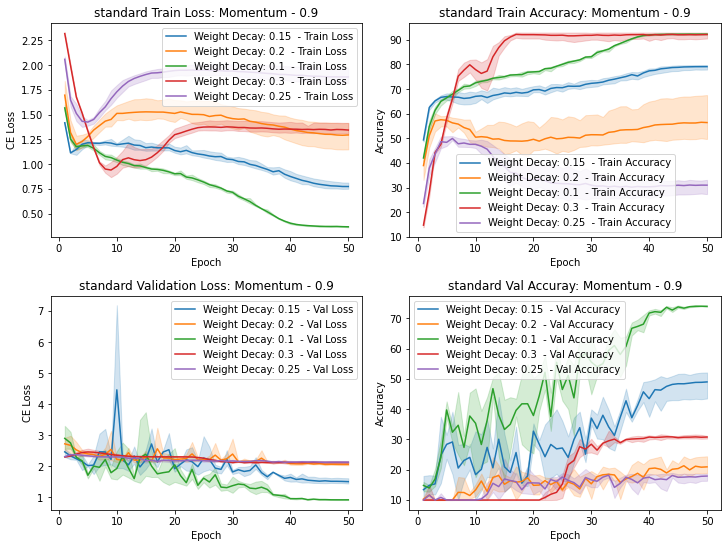

In [75]:
plot_momentum(standard_metadata, standard_logs, 'standard')

In [76]:
def plot_test_results_(base, trunc, standard, type_):
    for i, mom in enumerate(base.momentum.unique()): 
        logs_ = base[base.momentum == mom].sort_values(by=['weight_decay'])
        trunc_logs_ = trunc[trunc.momentum == mom].sort_values(by=['weight_decay'])
        standard_logs_ = standard[standard.momentum == mom].sort_values(by=['weight_decay'])
        sns.lineplot(data=logs_, x='weight_decay', y='test_prec1', label='base', color='red')
        sns.lineplot(data=trunc_logs_, x='weight_decay', y='test_prec1', label='trunc ce')
        sns.lineplot(data=standard_logs_, x='weight_decay', y='test_prec1', label='standard')
        plt.xlabel('Weight Decay')
        plt.ylabel('Accuracy')
        plt.title('{} Test Accuracy : {} Momentum'.format(type_, mom))
        plt.legend()
        plt.show()

In [77]:
# iterate over learning rates
def filter_(metadata, unseen, test, trunc_train, train_base):
    for i, weight_decay in enumerate(metadata.weight_decay.unique()): 
        # use .apply() to find exp id for every experiment                       
        unseen['weight_decay'] =  unseen.apply(lambda row: metadata[metadata.exp_id == row['exp_id']]['weight_decay'], axis=1)
        test['weight_decay'] = test.apply(lambda row: metadata[metadata.exp_id == row['exp_id']]['weight_decay'], axis=1)
        trunc_train['weight_decay'] = trunc_train.apply(lambda row: metadata[metadata.exp_id == row.exp_id]['weight_decay'], axis=1)
        train_base['weight_decay'] = train_base.apply(lambda row: metadata[metadata.exp_id == row.exp_id]['weight_decay'], axis=1)
    
    # iterate over learning rates
    for i, mom in enumerate(metadata.momentum.unique()): 

        # use .apply() to find exp id for every experiment                       
        unseen['momentum'] =  unseen.apply(lambda row: metadata[metadata.exp_id == row['exp_id']]['momentum'], axis=1)
        test['momentum'] = test.apply(lambda row: metadata[metadata.exp_id == row['exp_id']]['momentum'], axis=1)
        trunc_train['momentum'] = trunc_train.apply(lambda row: metadata[metadata.exp_id == row.exp_id]['momentum'], axis=1)
        train_base['momentum'] = train_base.apply(lambda row: metadata[metadata.exp_id == row.exp_id]['momentum'], axis=1)
        

    return unseen, test, trunc_train, train_base

unseen_, test_, trunc_train_, train_base_ = filter_(base_metadata, unseen, test, trunc_train, train_base)
trunc_unseen_, trunc_test_, trunc_trunc_train_, trunc_train_base_ = filter_(trunc_metadata, trunc_unseen, trunc_test, trunc_trunc_train, trunc_train_base)
standard_unseen_, standard_test_, standard_trunc_train_, standard_train_base_ = filter_(standard_metadata, standard_unseen, standard_test, standard_trunc_train, standard_train_base)

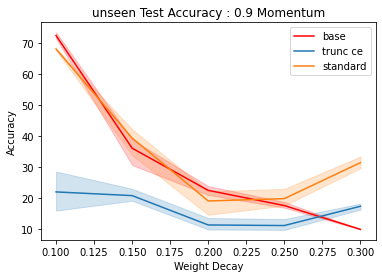

In [78]:
plot_test_results_(unseen_, trunc_unseen_, standard_unseen_, 'unseen')

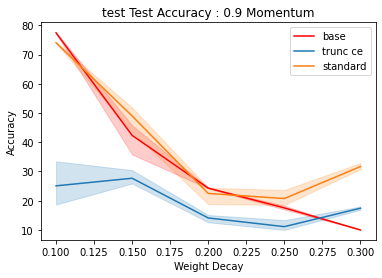

In [79]:
plot_test_results_(test_, trunc_test_, standard_test_, 'test')

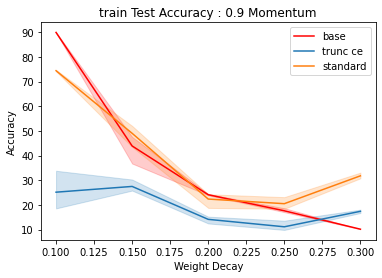

In [80]:
plot_test_results_(train_base_, trunc_train_base_, standard_train_base_, 'train')